# Plant Disease Predictor Using CNN's - Image Classification

## Seeding for Reproducibility of Results

In [ ]:
# Setting the seeds for reproducibility
# Internally some random process happens (e.g if we're building a neural network and it trains)
# Each time you run the code it might give slightly different results
# Thus we set a seed to prevent this --> consistent results
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

## Install other Dependencies

In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


## Data Curation from Kaggle

In [ ]:
!pip install kaggle

In [ ]:
# Set up environemtn variables
kaggle_credentials = json.load(open("kaggle.json"))
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.03G/2.04G [00:37<00:00, 81.6MB/s]
100% 2.04G/2.04G [00:37<00:00, 57.7MB/s]


In [ ]:
# Unzip the dataset downloaded from kaggle
with ZipFile('plantvillage-dataset.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
# Test
!ls

 kaggle.json  'plantvillage dataset'   plantvillage-dataset.zip   sample_data


In [ ]:
# For the disease classification we will use the color dataset as it is logically important and relevant for disease detection
print(os.listdir("plantvillage dataset"))

['segmented', 'color', 'grayscale']


In [ ]:
data = os.listdir("plantvillage dataset")
for i in data:
  print(len(i))

9
5
9


Data Explanation:
The Data set includes three variants of images: Color, Grayscale, and Segmented. For our predictive model, we will make use of the color dataset. The color dataset include images of specific plants with a visible disease. Our model aims to learn from this set of images and thus be able to predict what disease a specific plant is afflicted with when provided an image.

In [ ]:
# Dataset Path
base_path = "plantvillage dataset/color"

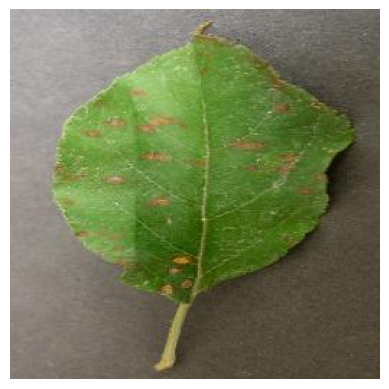

(256, 256, 3)
[[[179 175 176]
  [181 177 178]
  [184 180 181]
  ...
  [115 112 105]
  [108 105  98]
  [101  98  91]]

 [[176 172 173]
  [177 173 174]
  [178 174 175]
  ...
  [113 110 103]
  [111 108 101]
  [109 106  99]]

 [[180 176 177]
  [180 176 177]
  [180 176 177]
  ...
  [108 105  98]
  [111 108 101]
  [114 111 104]]

 ...

 [[137 128 119]
  [131 122 113]
  [125 116 107]
  ...
  [ 74  65  48]
  [ 74  65  48]
  [ 73  64  47]]

 [[136 127 118]
  [132 123 114]
  [128 119 110]
  ...
  [ 77  69  50]
  [ 75  67  48]
  [ 75  67  48]]

 [[133 124 115]
  [133 124 115]
  [132 123 114]
  ...
  [ 81  73  54]
  [ 80  72  53]
  [ 79  71  52]]]


In [ ]:
image_path = "/content/plantvillage dataset/color/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG"

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

# you want the images of the training and testing set to be of the same shape
# needs to be uniform
# Note the third value in the shape represents the colour
# 3 -> RGB, no value -> grayscale
print(img.shape)
print(img) # This will give us an array of pixel data of the image - RGB from 0 - 255

In [ ]:
# Image params
img_size = 224
batch_size = 32

## Train Test Split

In [ ]:
# Image Data Generators
# The train_gen and validation_gen handles the entire train-test split for us!

# 0.2 validation means using 20% of the data for validation
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
# Train Generator
train_gen = data_gen.flow_from_directory(
    base_path,
    target_size=(img_size, img_size), # Resized image to 224
    batch_size=batch_size, # Each batch has 32 images, can be larger if more compute power -> memory intensive
    subset='training', # training data - 80% flowing into train_gen -> rest is in validation_gen
    class_mode='categorical'
)

# Its split the images across each class (folder in the color directory)

Found 43456 images belonging to 38 classes.


In [ ]:
# Validation Generator
validation_gen = data_gen.flow_from_directory(
    base_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 10849 images belonging to 38 classes.


## Convolutional Neural Network (CNN)

### Define the Model

In [ ]:
# Define the model
model = models.Sequential()

# Sequential - used when we have a linear stack of layers
# Each layers accepts a tensor and then outputs a tensor
# Conv2D is the 2 dimensional convolutional layer with a 32 kernel, (3, 3) matrix

# First Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Second Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Purpose of flattening is to be able to pass into Dense layer which requires 1D
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(train_gen.num_classes, activation='softmax')) # Top/output layer -> predicts class

# Softmax is good for multiclass, if the data was binary I'd probably use sigmoid
# 38 neurons in output layer, each one having a value equal to the probability that it is the class



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Summary

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      47,776,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,805,158 (182.36 MB)

 Trainable params: 47,805,158 (182.36 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling and Training the Model




In [ ]:
# Select your optimizer, loss function and metric
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Training the model

history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size, # number of steps per each epoch
    epochs=5, # number of epochs
    validation_data=validation_gen, # validation data
    validation_steps=validation_gen.samples // batch_size # number of steps in validation
)

Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 127s 89ms/step - accuracy: 0.5823 - loss: 1.8610 - val_accuracy: 0.8666 - val_loss: 0.4270
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1s 373us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0872
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 97s 71ms/step - accuracy: 0.9109 - loss: 0.2786 - val_accuracy: 0.8786 - val_loss: 0.4015
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.4361
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 143s 71ms/step - accuracy: 0.9660 - loss: 0.1069 - val_accuracy: 0.8547 - val_loss: 0.5241


### Model Evaluation

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_gen)
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Loss: {val_loss}")

340/340 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.8539 - loss: 0.5375
Validation Accuracy: 0.8547331690788269
Validation Loss: 0.5240291953086853


### Plot Training and Validation + Loss Accuracy Values

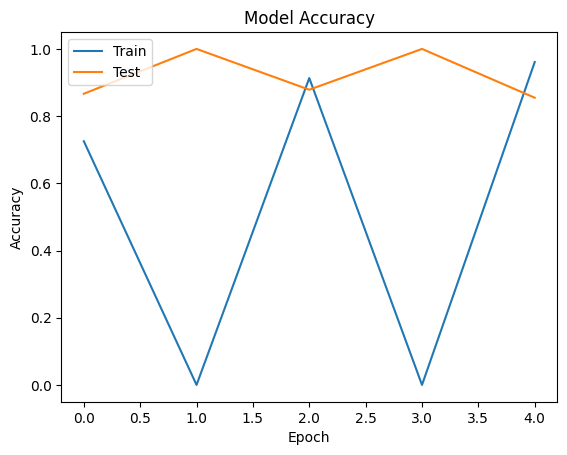

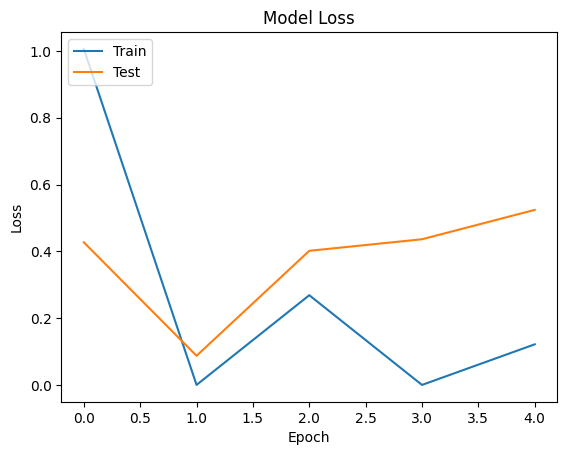

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# The weird dips at 2 and 4 are because that specific epoch failed to train
# With this error: Your input ran out of data; interrupting training.
# Will Fix and retrain

### Process Image

In [ ]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image_array = np.array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_array.astype("float32") / 255.0
    return image_array

def predict_disease(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [ ]:
# map the class indices to the class names
class_indices = {v: k for k, v in train_gen.class_indices.items()}
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [ ]:
# Save the class names as a json file
json.dump(class_indices, open("class_indices.json", "w"))

## Testing with an Example!

In [ ]:
image_paths = ["/content/test_apple_black_rot.JPG", "/content/test_blueberry_healthy.jpg", "/content/test_potato_early_blight.jpg"]

predicted_class = []

for image in image_paths:
  predicted_class.append(predict_disease(model, image, class_indices))

# CORRECT EVERY TIME!
predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


['Apple___Black_rot', 'Blueberry___healthy', 'Potato___Early_blight']

# Save the Model

In [ ]:
model.save('drive/MyDrive/plant_disease_predictor.keras')